In [144]:
import os
import numpy as np
import pandas as pd
import networkx as nx 
import matplotlib.pyplot as plt
import scipy.io
mat = scipy.io.loadmat('./syndata_10.mat')

In [3]:
mat['adjmat_out'][0,:].shape

(1000,)

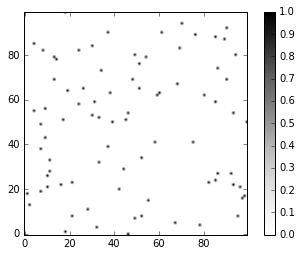

In [13]:
%matplotlib inline
plt.imshow(mat['adjmat_out'][0,:][0], origin='lower', cmap='Greys')
plt.colorbar()

In [17]:
def adjmat2edge(fname, adjmat, weighted=False, graph='directed'):
    """
    Convert adjancent matrix to edge representation.
    """
    with open(fname, 'w') as fp:
        for i in xrange(adjmat.shape[0]):
            for j in xrange(adjmat.shape[1]):
                if graph == 'directed':
                    if adjmat[i,j] > 0:
                        if weighted:
                            fp.write('%i %i %f\n' %(i,j,adjmat[i,j]))
                        else:
                            fp.write('%i %i\n' %(i,j))

In [18]:
adjmat2edge('node2vec/graph/synedge', mat['adjmat_out'][0,:][0])

In [9]:
!python node2vec/src/main.py --help

Using TensorFlow backend.
usage: main.py [-h] [--input [INPUT]] [--output [OUTPUT]]
               [--dimensions DIMENSIONS] [--walk-length WALK_LENGTH]
               [--num-walks NUM_WALKS] [--window-size WINDOW_SIZE]
               [--iter ITER] [--workers WORKERS] [--p P] [--q Q] [--weighted]
               [--unweighted] [--directed] [--undirected]

Run node2vec.

optional arguments:
  -h, --help            show this help message and exit
  --input [INPUT]       Input graph path
  --output [OUTPUT]     Embeddings path
  --dimensions DIMENSIONS
                        Number of dimensions. Default is 128.
  --walk-length WALK_LENGTH
                        Length of walk per source. Default is 80.
  --num-walks NUM_WALKS
                        Number of walks per source. Default is 10.
  --window-size WINDOW_SIZE
                        Context size for optimization. Default is 10.
  --iter ITER           Number of epochs in SGD
  --workers WORKERS     Number of parallel workers. 

In [68]:
!python node2vec/src/main.py --input node2vec/graph/synedge --output node2vec/emb/syn.emd --directed --dimensions 2

Using TensorFlow backend.
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [161]:
def read_emb(fname):
    """
    Read the output files from node2vec/deepwalk.
    """
    res = []
    with open(fname, 'r') as fp:
        line = fp.readline().split()
        nnodes, ndim = int(line[0]), int(line[1])
        for i in xrange(nnodes):
            line = map(float, fp.readline().split())
            res.append([line[i] for i in xrange(ndim+1)])
    return np.array(res)

def emb_labels(emb):
    """
    Plot the latent space.
    """
    plt.scatter(emb[:,1], emb[:,2])
    for label, x, y in emb:
        plt.annotate(
            str(int(label)),
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.1', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
def run_walk(fname, dim):
    """
    Run node2vec/deepwalk in d latent space
    """
    os.system("python node2vec/src/main.py --input node2vec/graph/" + fname + " --output node2vec/emb/" + fname + "hh.emd --p 100 --q 100 --dimensions " + str(dim))
    os.system("python node2vec/src/main.py --input node2vec/graph/" + fname + " --output node2vec/emb/" + fname + "ll.emd --p 0.01 --q 0.01 --dimensions " + str(dim))
    os.system("python node2vec/src/main.py --input node2vec/graph/" + fname + " --output node2vec/emb/" + fname + "lh.emd --p 0.01 --q 100 --dimensions " + str(dim))
    os.system("python node2vec/src/main.py --input node2vec/graph/" + fname + " --output node2vec/emb/" + fname + "hl.emd --p 100 --q 0.01 --dimensions " + str(dim))
    os.system("python node2vec/src/main.py --input node2vec/graph/" + fname + " --output node2vec/emb/" + fname + "11.emd --p 1 --q 1 --dimensions " + str(dim))
    os.system("deepwalk --format edgelist --input node2vec/graph/" + fname + " --output deepwalk/emb/" + fname + "dw.emd --representation-size " + str(dim))
    
    plt.figure(figsize=(12,12))
    plt.subplot(3, 2, 1)
    emb = read_emb("node2vec/emb/" + fname + "hh.emd")
    if dim > 2:
        pca.fit(emb[:,1:])
        X = pca.transform(emb[:,1:])
        emb_labels(np.hstack((emb[:,0][:,None],X)))
    else:
        emb_labels(emb)
    plt.title('$p=100, q=100$')
    plt.subplot(3, 2, 2)
    emb = read_emb("node2vec/emb/" + fname + "ll.emd")
    if dim > 2:
        pca.fit(emb[:,1:])
        X = pca.transform(emb[:,1:])
        emb_labels(np.hstack((emb[:,0][:,None],X)))
    else:
        emb_labels(emb)
    plt.title('$p=0.01, q=0.01$')
    plt.subplot(3, 2, 3)
    emb = read_emb("node2vec/emb/" + fname + "lh.emd")
    if dim > 2:
        pca.fit(emb[:,1:])
        X = pca.transform(emb[:,1:])
        emb_labels(np.hstack((emb[:,0][:,None],X)))
    else:
        emb_labels(emb)
    plt.title('$p=0.01, q=100$')
    plt.subplot(3, 2, 4)
    emb = read_emb("node2vec/emb/" + fname + "hl.emd")
    if dim > 2:
        pca.fit(emb[:,1:])
        X = pca.transform(emb[:,1:])
        emb_labels(np.hstack((emb[:,0][:,None],X)))
    else:
        emb_labels(emb)
    plt.title('$p=100, q=0.01$')
    plt.subplot(3, 2, 5)
    emb = read_emb("node2vec/emb/" + fname + "11.emd")
    if dim > 2:
        pca.fit(emb[:,1:])
        X = pca.transform(emb[:,1:])
        emb_labels(np.hstack((emb[:,0][:,None],X)))
    else:
        emb_labels(emb)
    plt.title('$p=1, q=1$')
    plt.subplot(3, 2, 6)
    emb = read_emb("deepwalk/emb/" + fname + "dw.emd")
    if dim > 2:
        pca.fit(emb[:,1:])
        X = pca.transform(emb[:,1:])
        emb_labels(np.hstack((emb[:,0][:,None],X)))
    else:
        emb_labels(emb)
    plt.title('deepwalk')

In [120]:
emb = read_emb('node2vec/emb/syn.emd')

In [122]:
plt.scatter(emb[:,1], emb[:,2])
for label, x, y in emb:
    plt.annotate(
        str(int(label)),
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

Name: 
Type: Graph
Number of nodes: 23
Number of edges: 21
Average degree:   1.8261


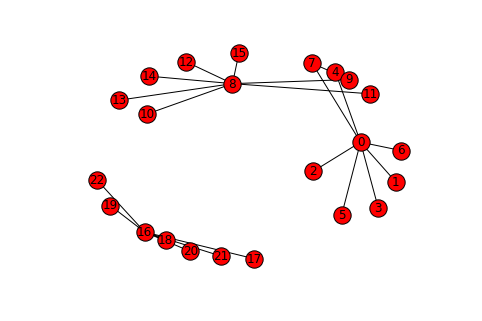

In [150]:
# generate one graph BFS & DFS
%matplotlib inline
ga_edges = pd.read_csv('node2vec/graph/testedge', sep=' ', header=None)
GA = nx.from_pandas_dataframe(ga_edges, source=0, target=1)
print(nx.info(GA))
nx.draw(GA, with_labels=True)

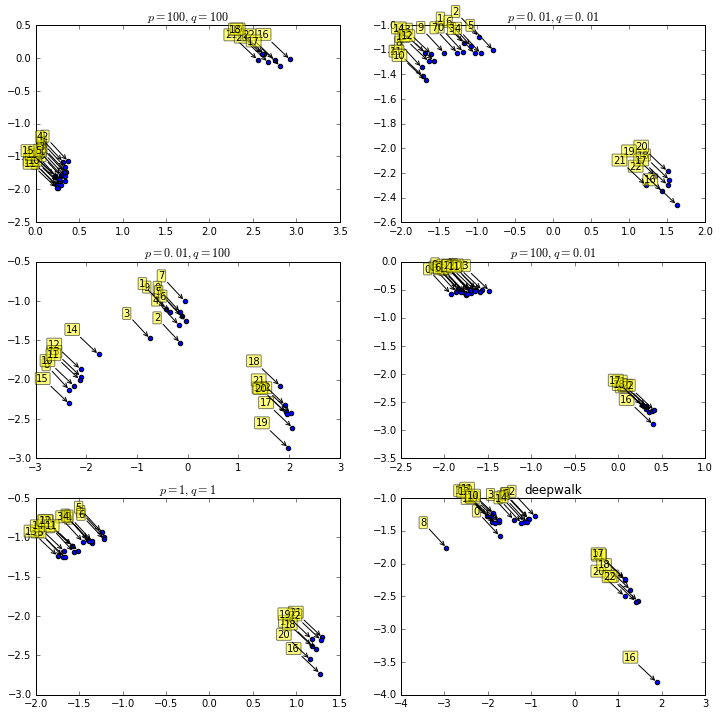

In [160]:
run_walk("testedge", 2)

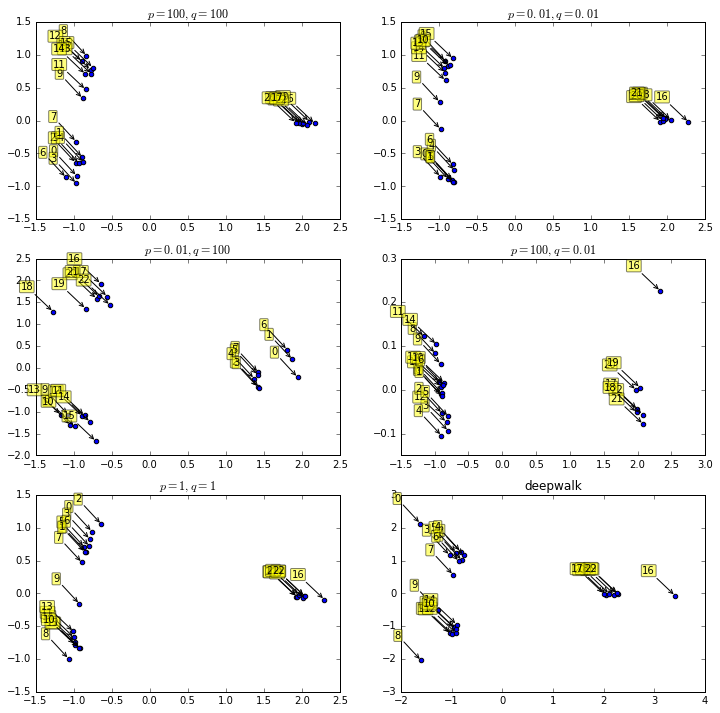

In [163]:
run_walk("testedge", 20)

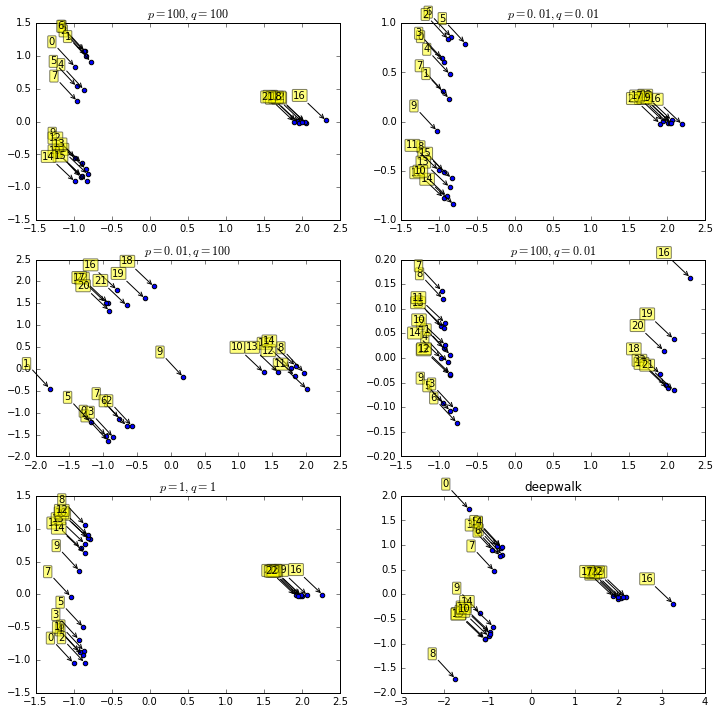

In [164]:
run_walk("testedge", 100)

Name: 
Type: Graph
Number of nodes: 14
Number of edges: 14
Average degree:   2.0000


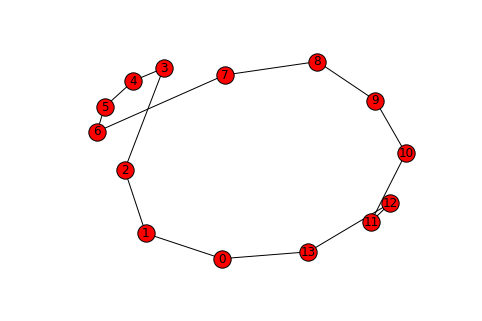

In [165]:
# generate one graph BFS & DFS
circ_edges = pd.read_csv('node2vec/graph/circular', sep=' ', header=None)
GC = nx.from_pandas_dataframe(circ_edges, source=0, target=1)
print(nx.info(GC))
nx.draw(GC, with_labels=True)

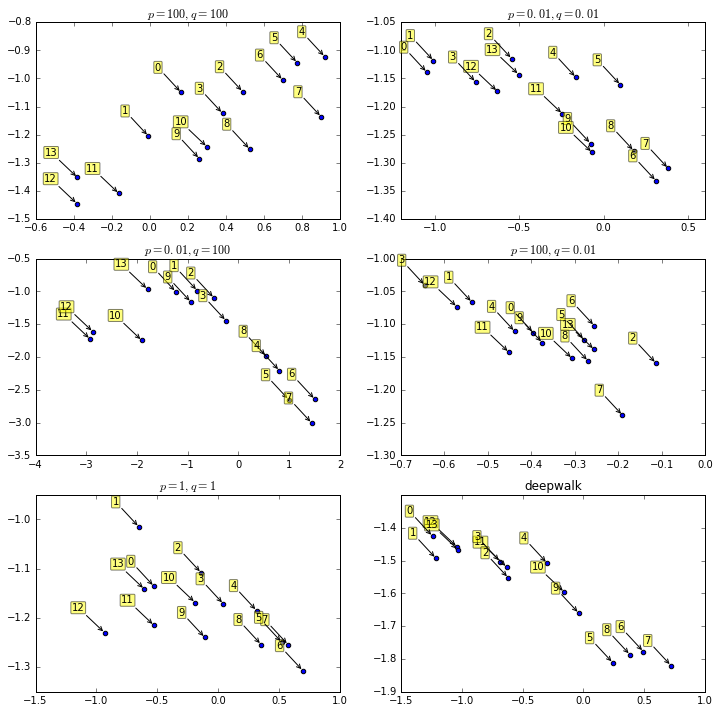

In [166]:
run_walk("circular", 2)

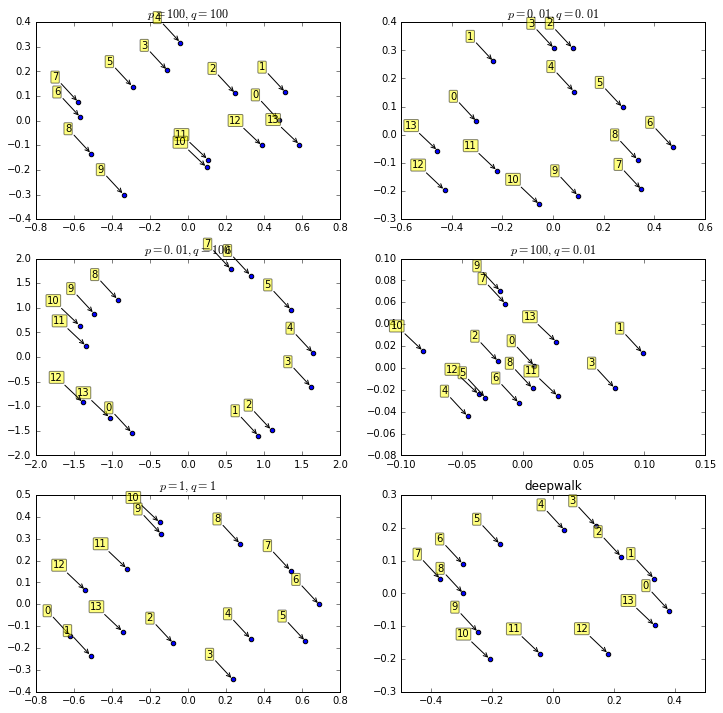

In [169]:
run_walk("circular", 20)

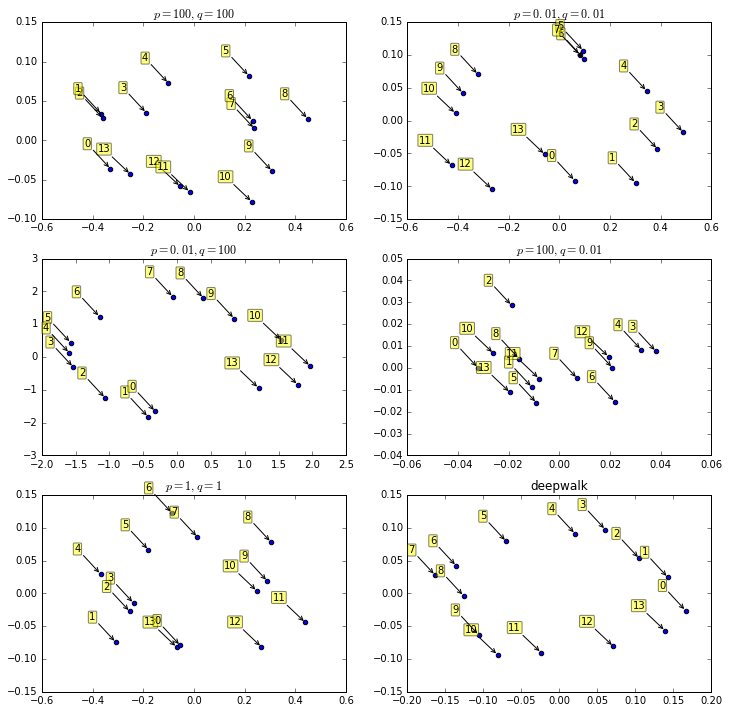

In [168]:
run_walk("circular", 100)

Name: 
Type: Graph
Number of nodes: 10
Number of edges: 10
Average degree:   2.0000


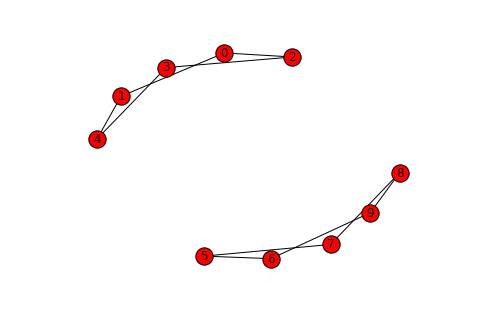

In [170]:
# generate one graph BFS & DFS
circ_edges = pd.read_csv('node2vec/graph/star', sep=' ', header=None)
GC = nx.from_pandas_dataframe(circ_edges, source=0, target=1)
print(nx.info(GC))
nx.draw(GC, with_labels=True)

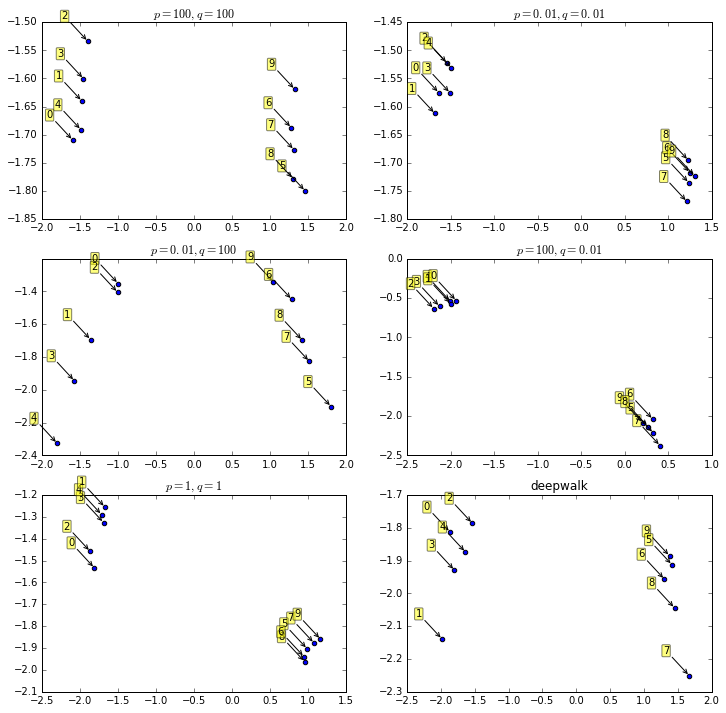

In [171]:
run_walk("star", 2)

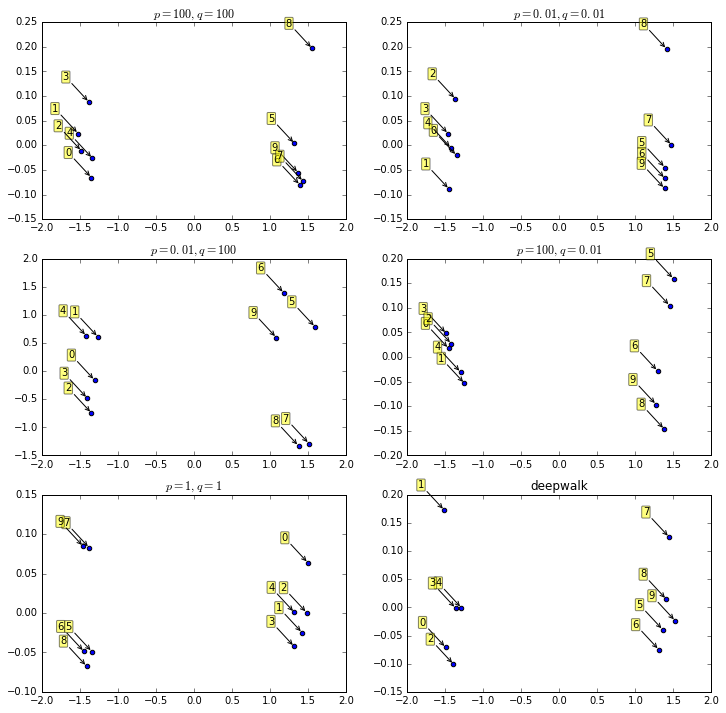

In [172]:
run_walk("star", 20)

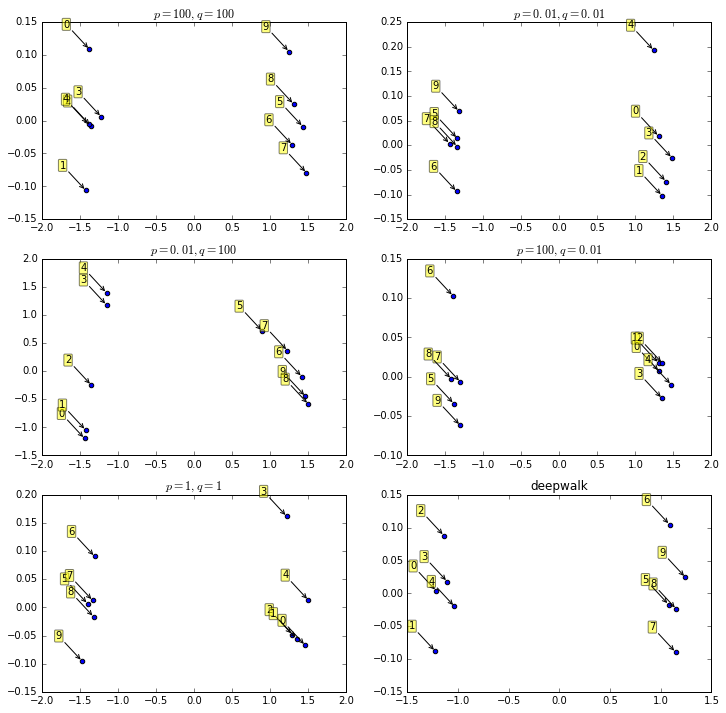

In [173]:
run_walk("star", 100)

Name: 
Type: Graph
Number of nodes: 15
Number of edges: 16
Average degree:   2.1333


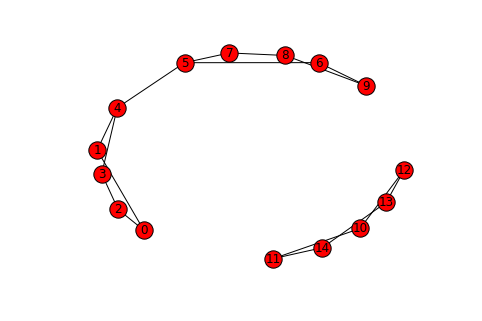

In [174]:
# generate one graph BFS & DFS
circ_edges = pd.read_csv('node2vec/graph/star2', sep=' ', header=None)
GC = nx.from_pandas_dataframe(circ_edges, source=0, target=1)
print(nx.info(GC))
nx.draw(GC, with_labels=True)

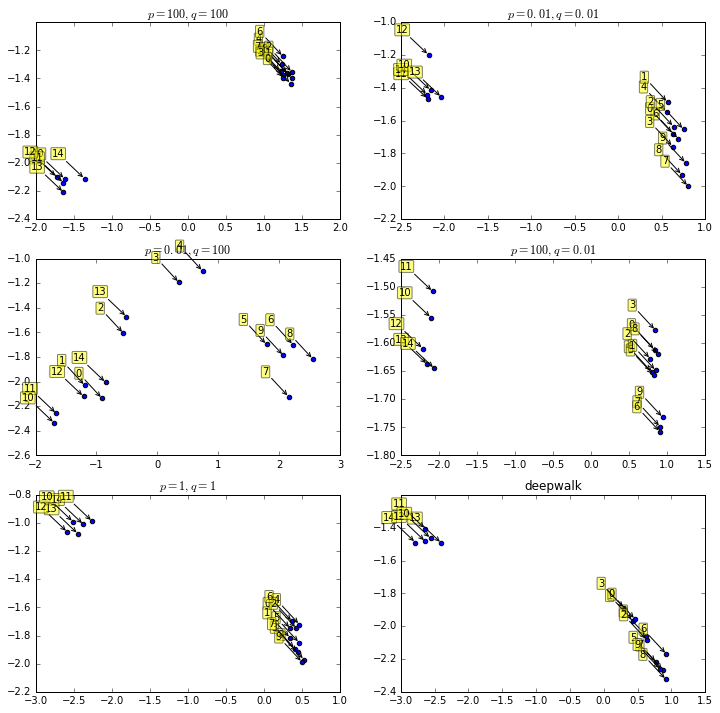

In [175]:
run_walk("star2", 2)

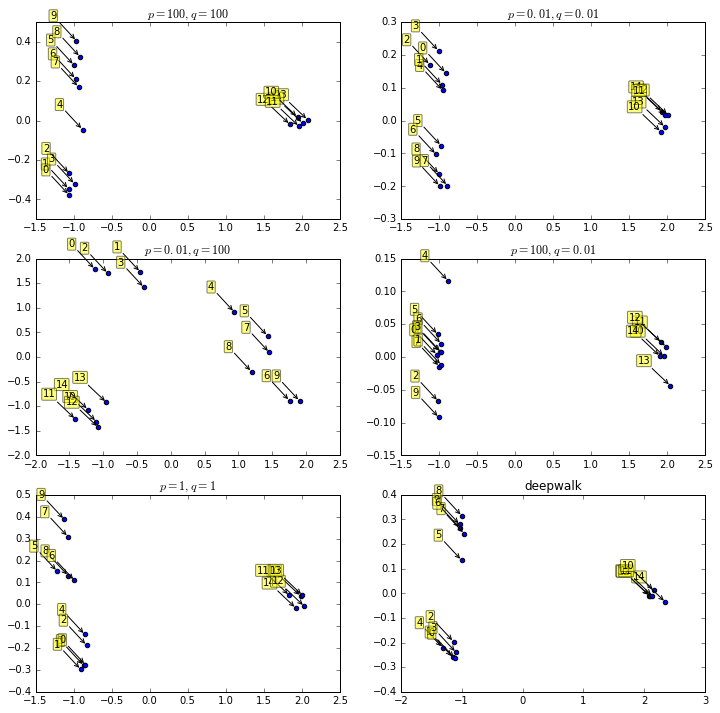

In [176]:
run_walk("star2", 20)

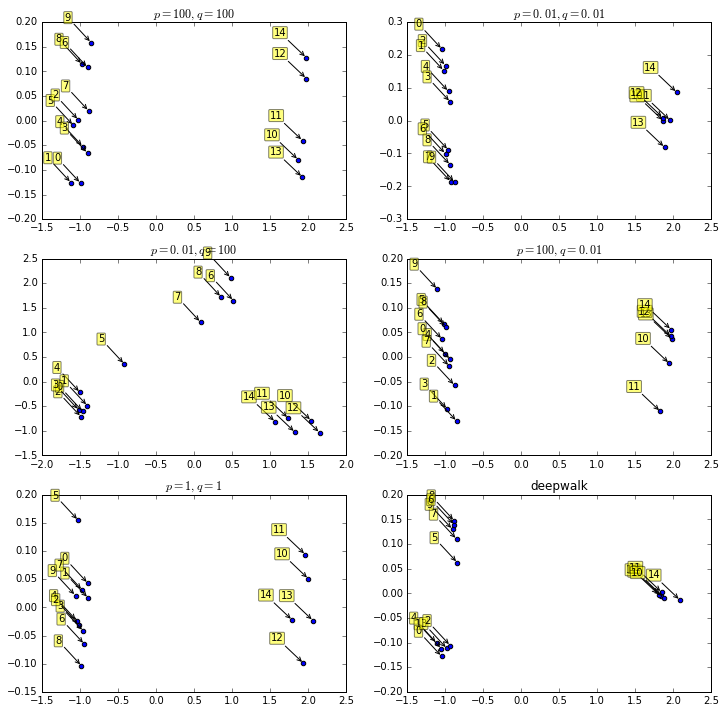

In [177]:
run_walk("star2", 100)